In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_absolute_error
from random import randint
from sklearn.model_selection import train_test_split
from utils import encode_numeric_zscore_list, chart_regression
import matplotlib.pylab as plt
import seaborn as sns
import math
import matplotlib.gridspec as gridspec
from scipy import stats
from sklearn.metrics import r2_score
%matplotlib inline

df = pd.read_csv('./data/o.csv')
#drop outliers
#df = df[df.TEST_RESULT_VALUE <= 500.0]
df.drop("LAB_CODE", inplace=True, axis=1)

In [6]:
df.shape

(322, 13)

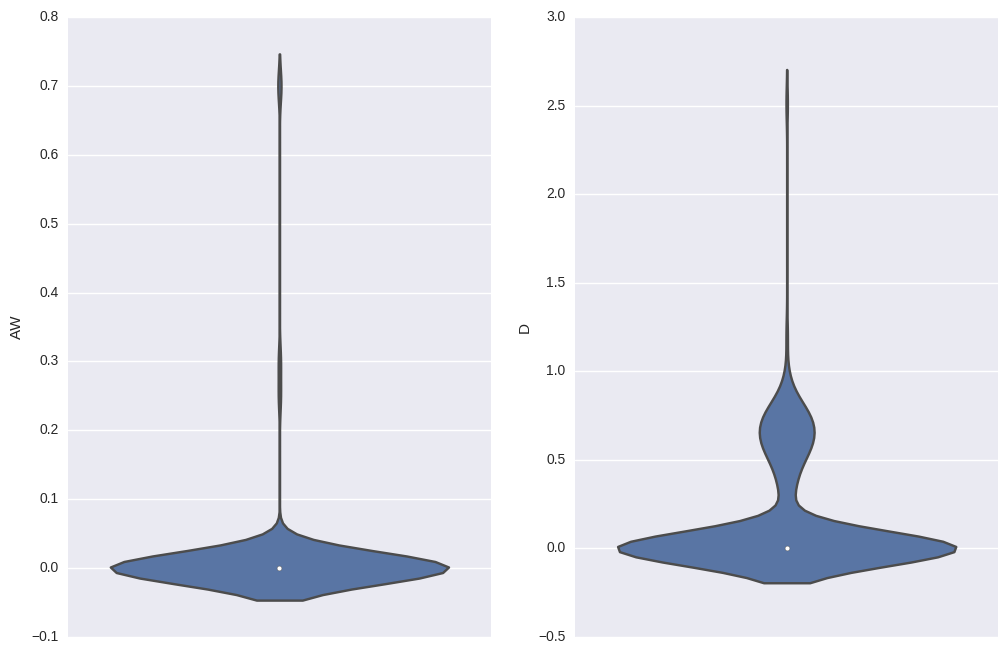

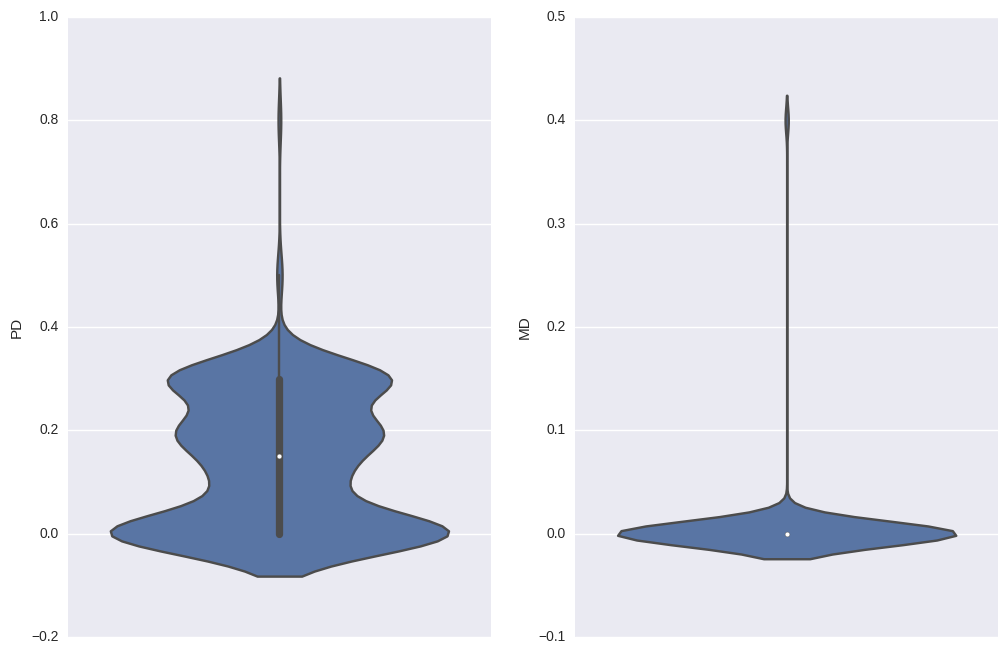

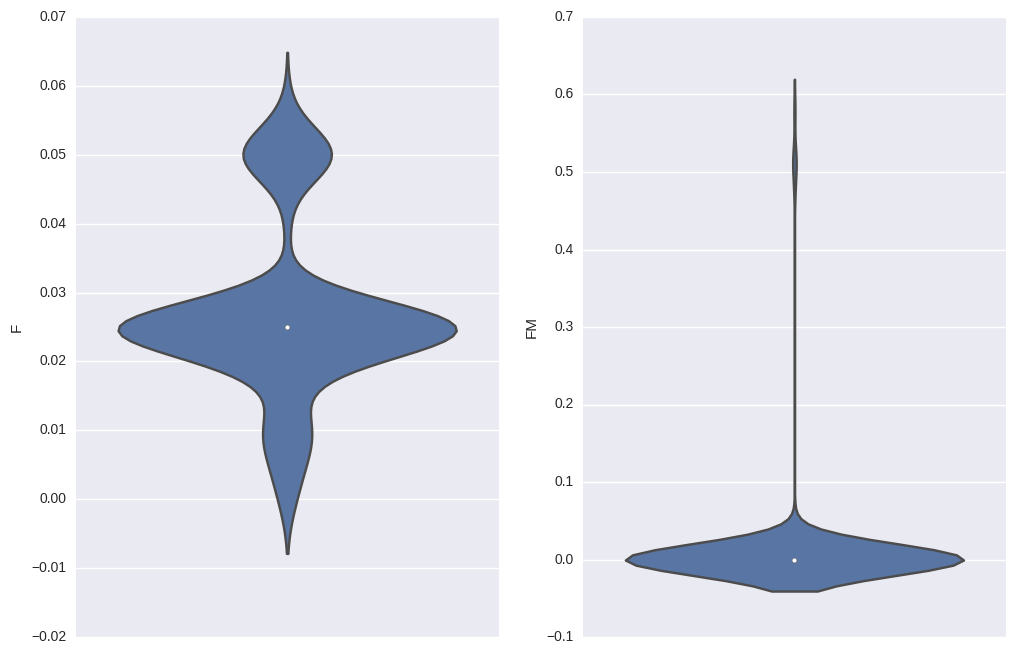

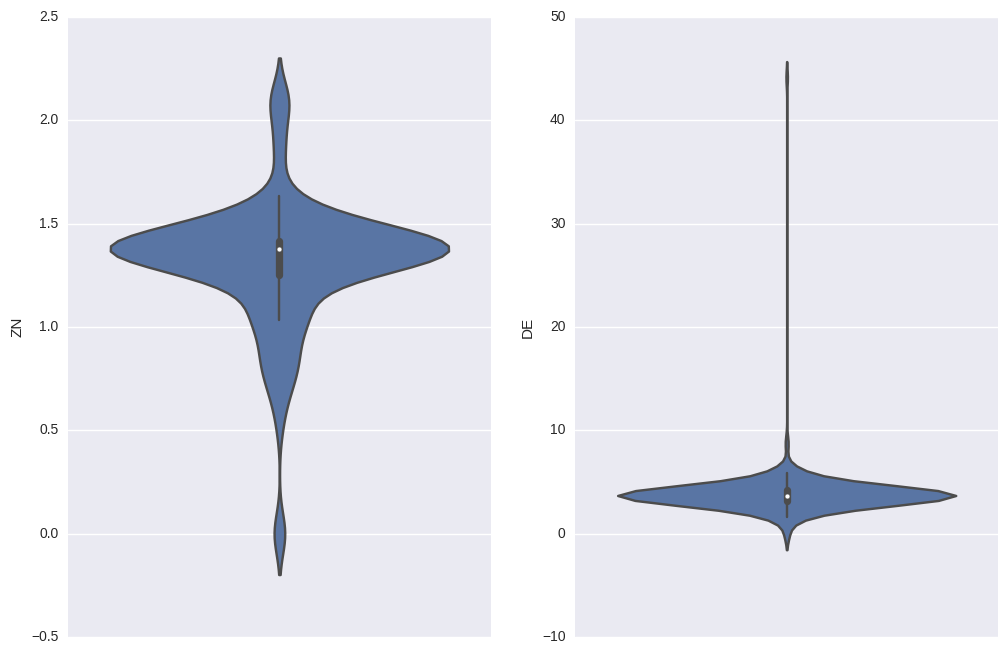

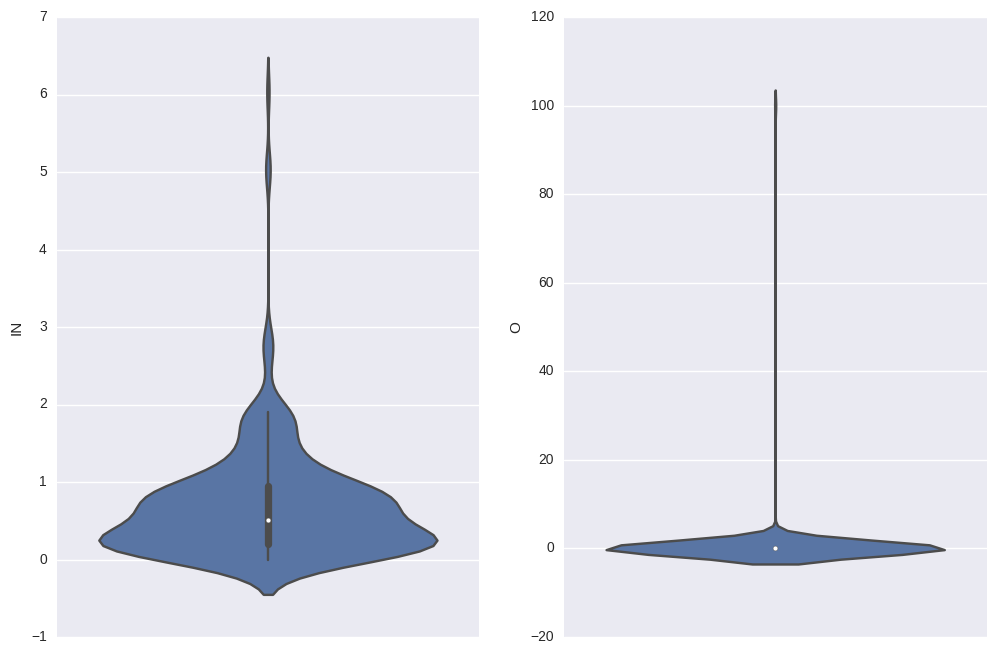

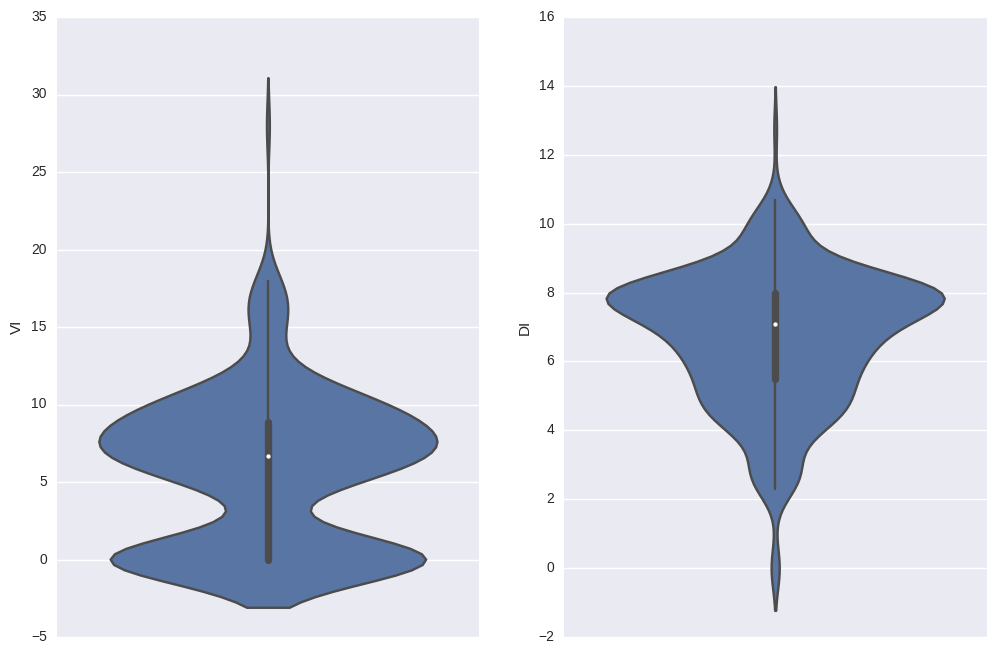

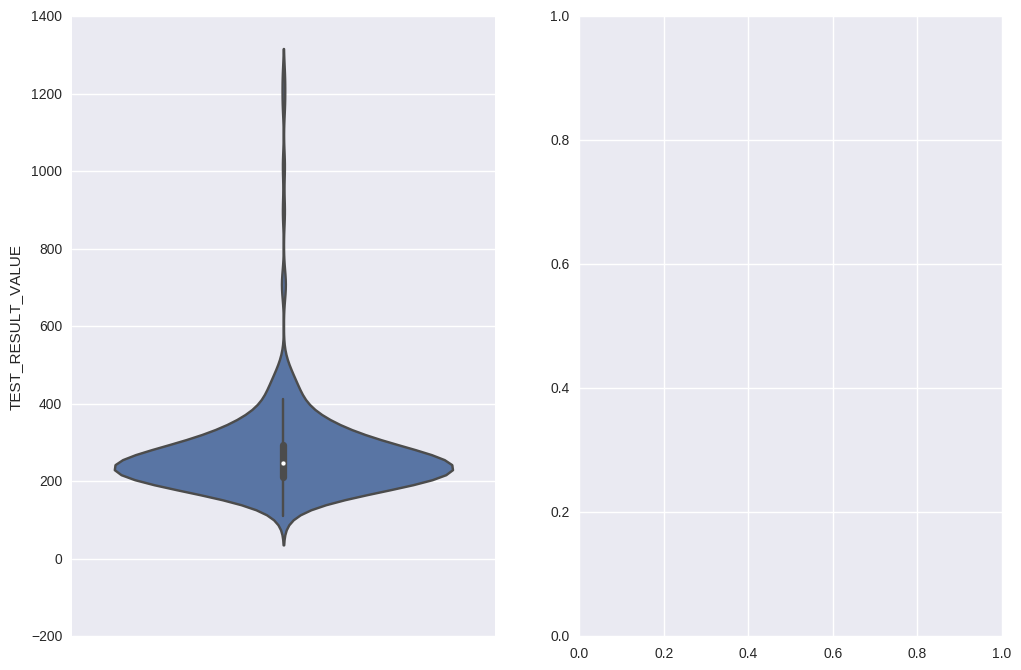

In [3]:
%matplotlib inline
#get the names of all the columns
cols=df.columns 
#Plot violin for all attributes in a 7x2 grid
n_cols = 2
n_rows = 7

for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(12, 8))
    for j in range(n_cols):
        index = i*n_cols+j
        
        if index < df.columns.shape[0]:        
            sns.violinplot(y=cols[i*n_cols+j], data=df, ax=ax[j])

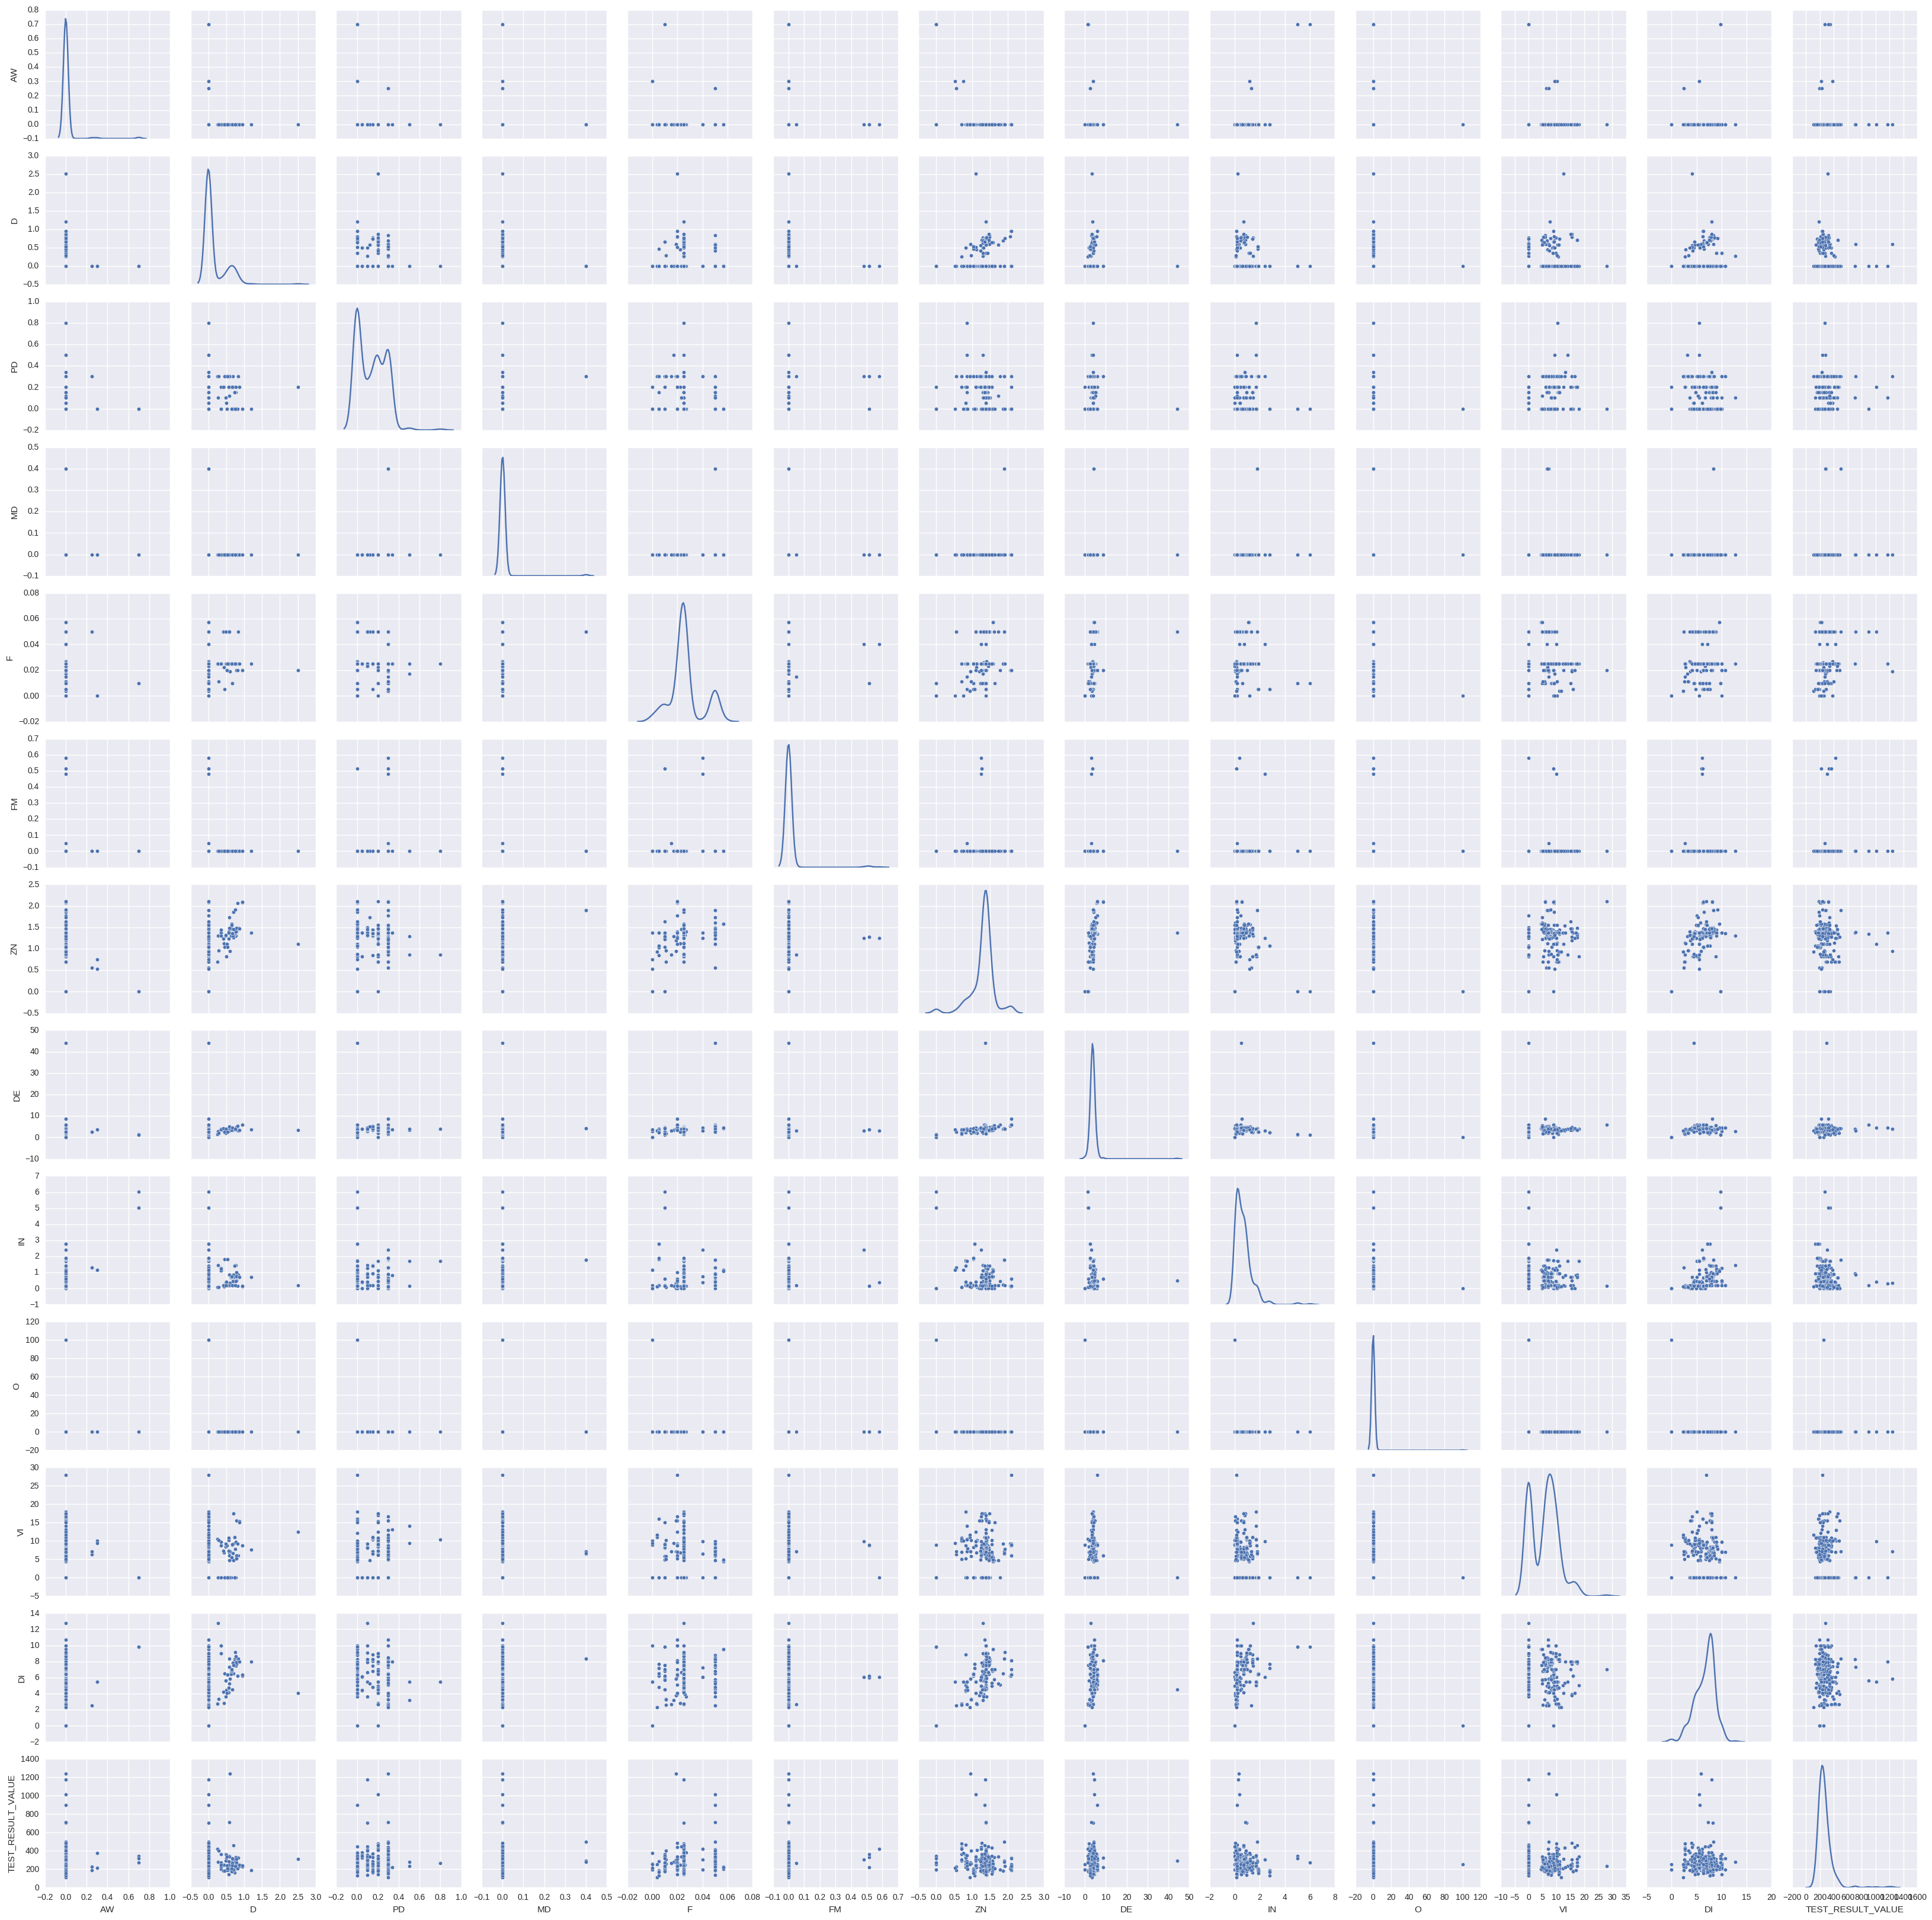

In [4]:
sns.pairplot(df, kind = 'scatter',diag_kind='kde')

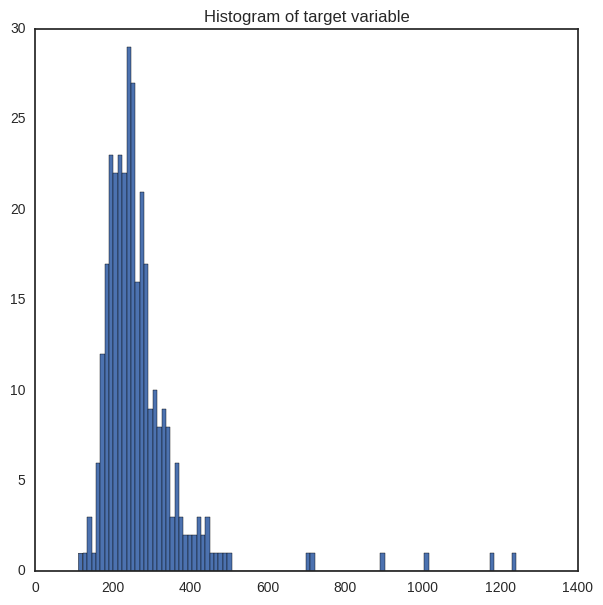

In [42]:
plt.figure(figsize=(7,7))
plt.hist(df.TEST_RESULT_VALUE, bins=100)
plt.title("Histogram of target variable")
plt.show()

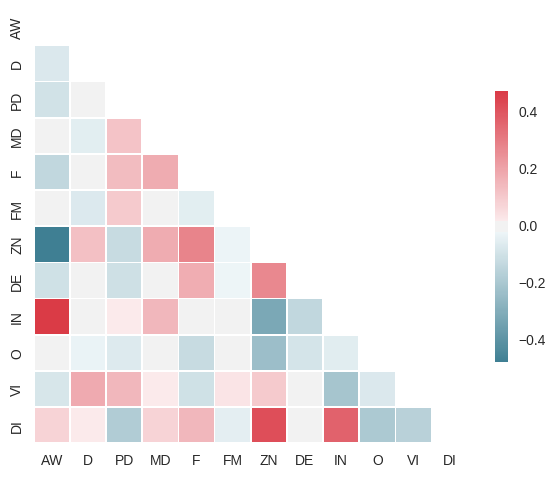

In [43]:
# Compute the correlation matrix
corr = df[['AW', 'D', 'PD', 'MD', 'F', 'FM', 'ZN', 'DE', 'IN', 'O', 'VI', 'DI']].corr()
sns.set(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

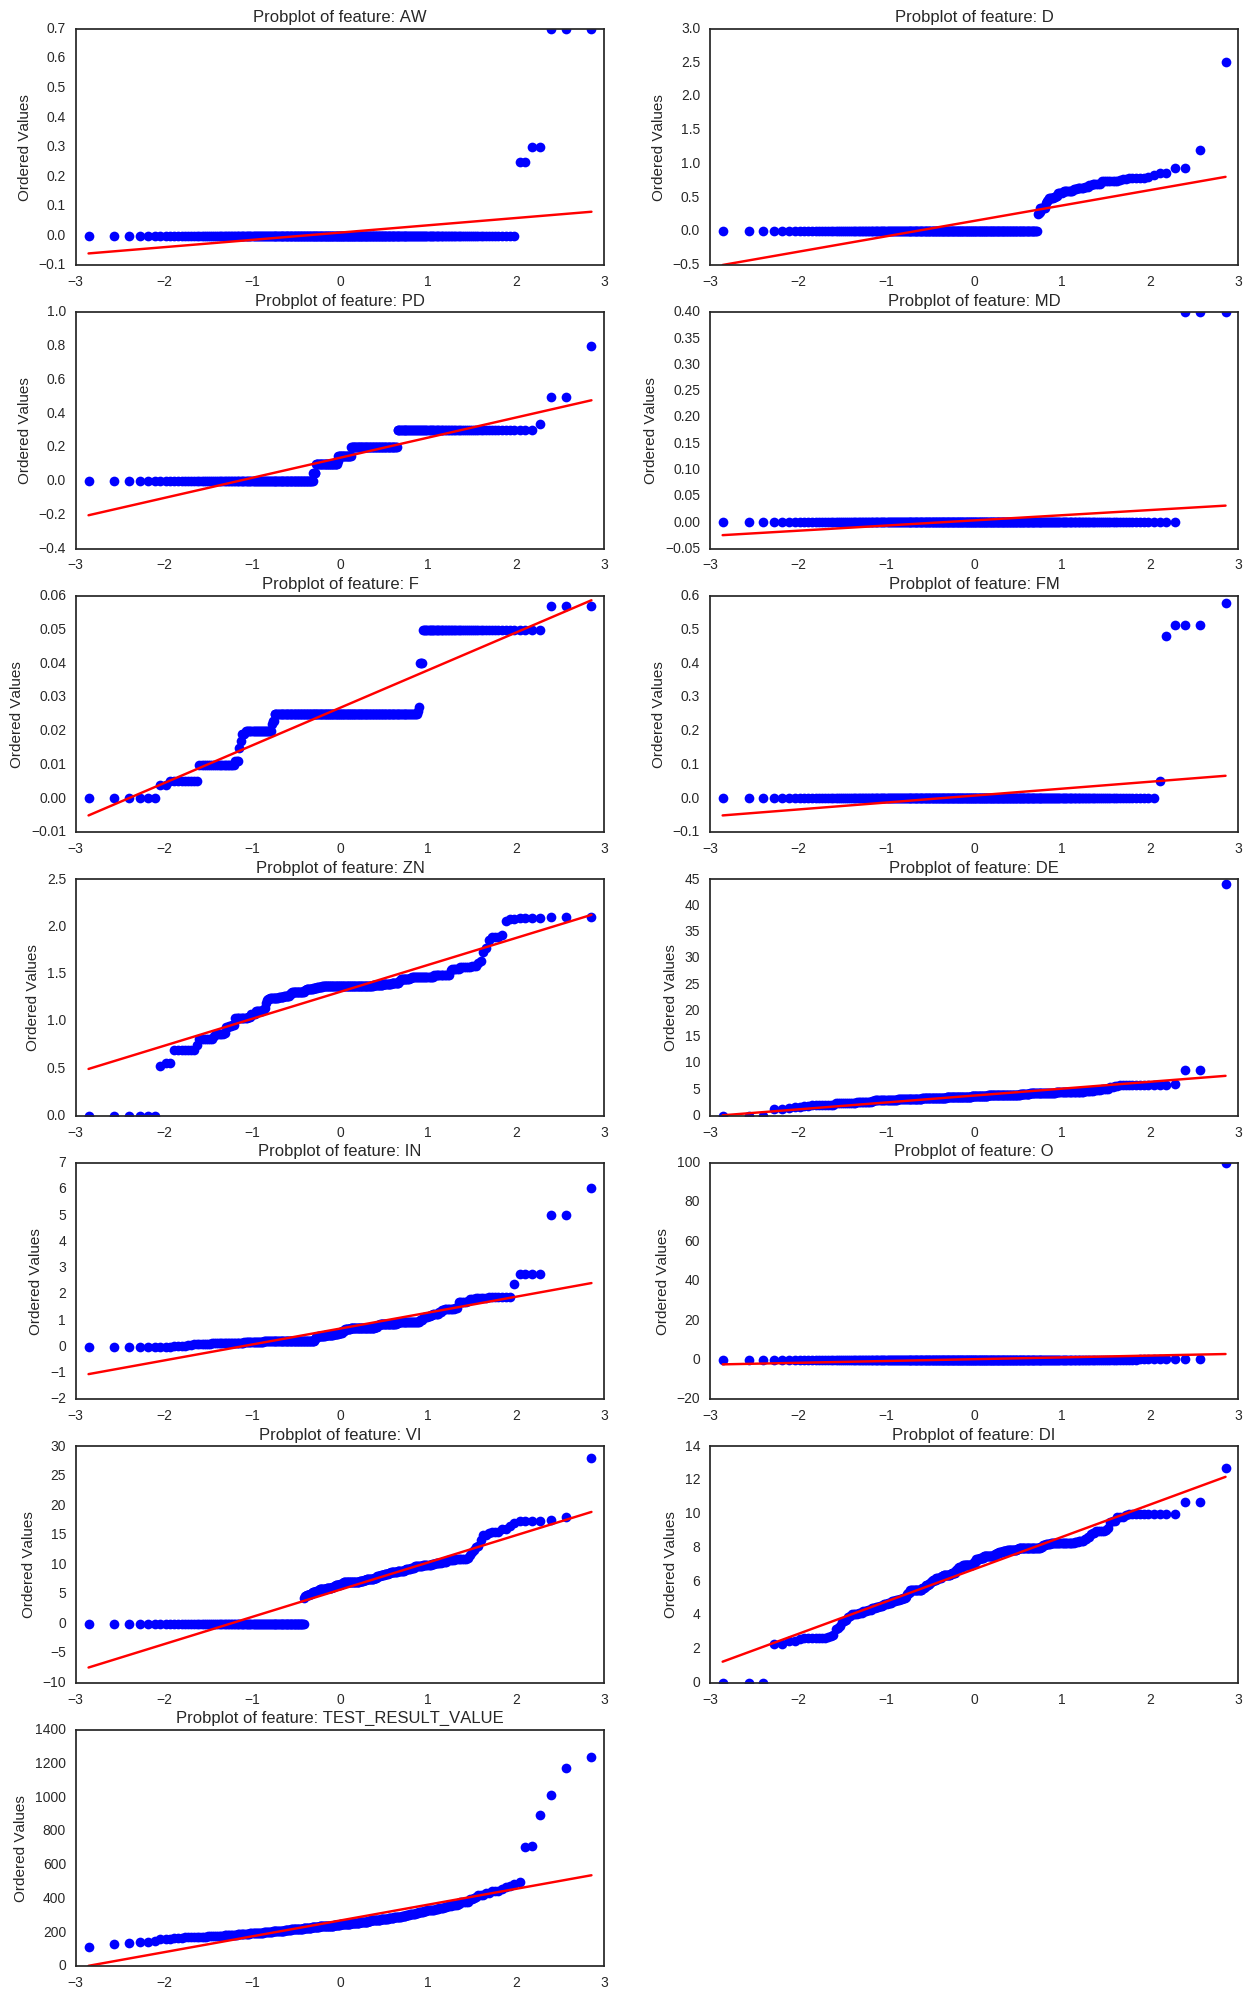

In [9]:
plt.figure(figsize=(15,25))
gs = gridspec.GridSpec(7, 2)
for i, cn in enumerate(df.columns):
    ax = plt.subplot(gs[i])
    stats.probplot(df[cn], dist = stats.norm, plot = ax)
    ax.set_xlabel('')
    ax.set_title('Probplot of feature: ' + cn)
plt.show()

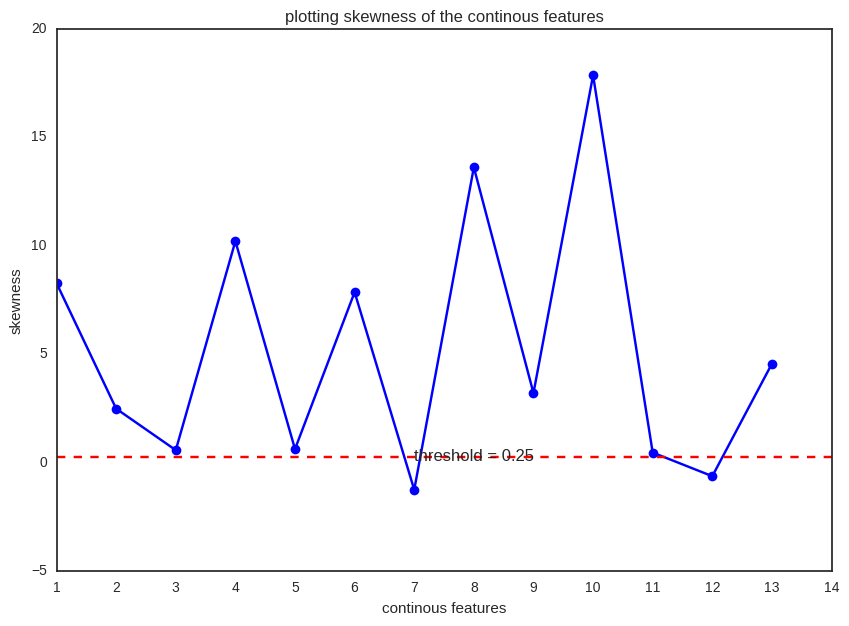

In [10]:
skewness_list = []
for cn in df.columns:
    skewness_list.append(stats.skew(df[cn]))

plt.figure(figsize=(10,7))
plt.plot(skewness_list, 'bo-')
plt.xlabel("continous features")
plt.ylabel("skewness")
plt.title("plotting skewness of the continous features")
plt.xticks(range(15), range(1,15,1))
plt.plot([(0.25) for i in range(0,14)], 'r--')
plt.text(6, .1, 'threshold = 0.25')
plt.show()

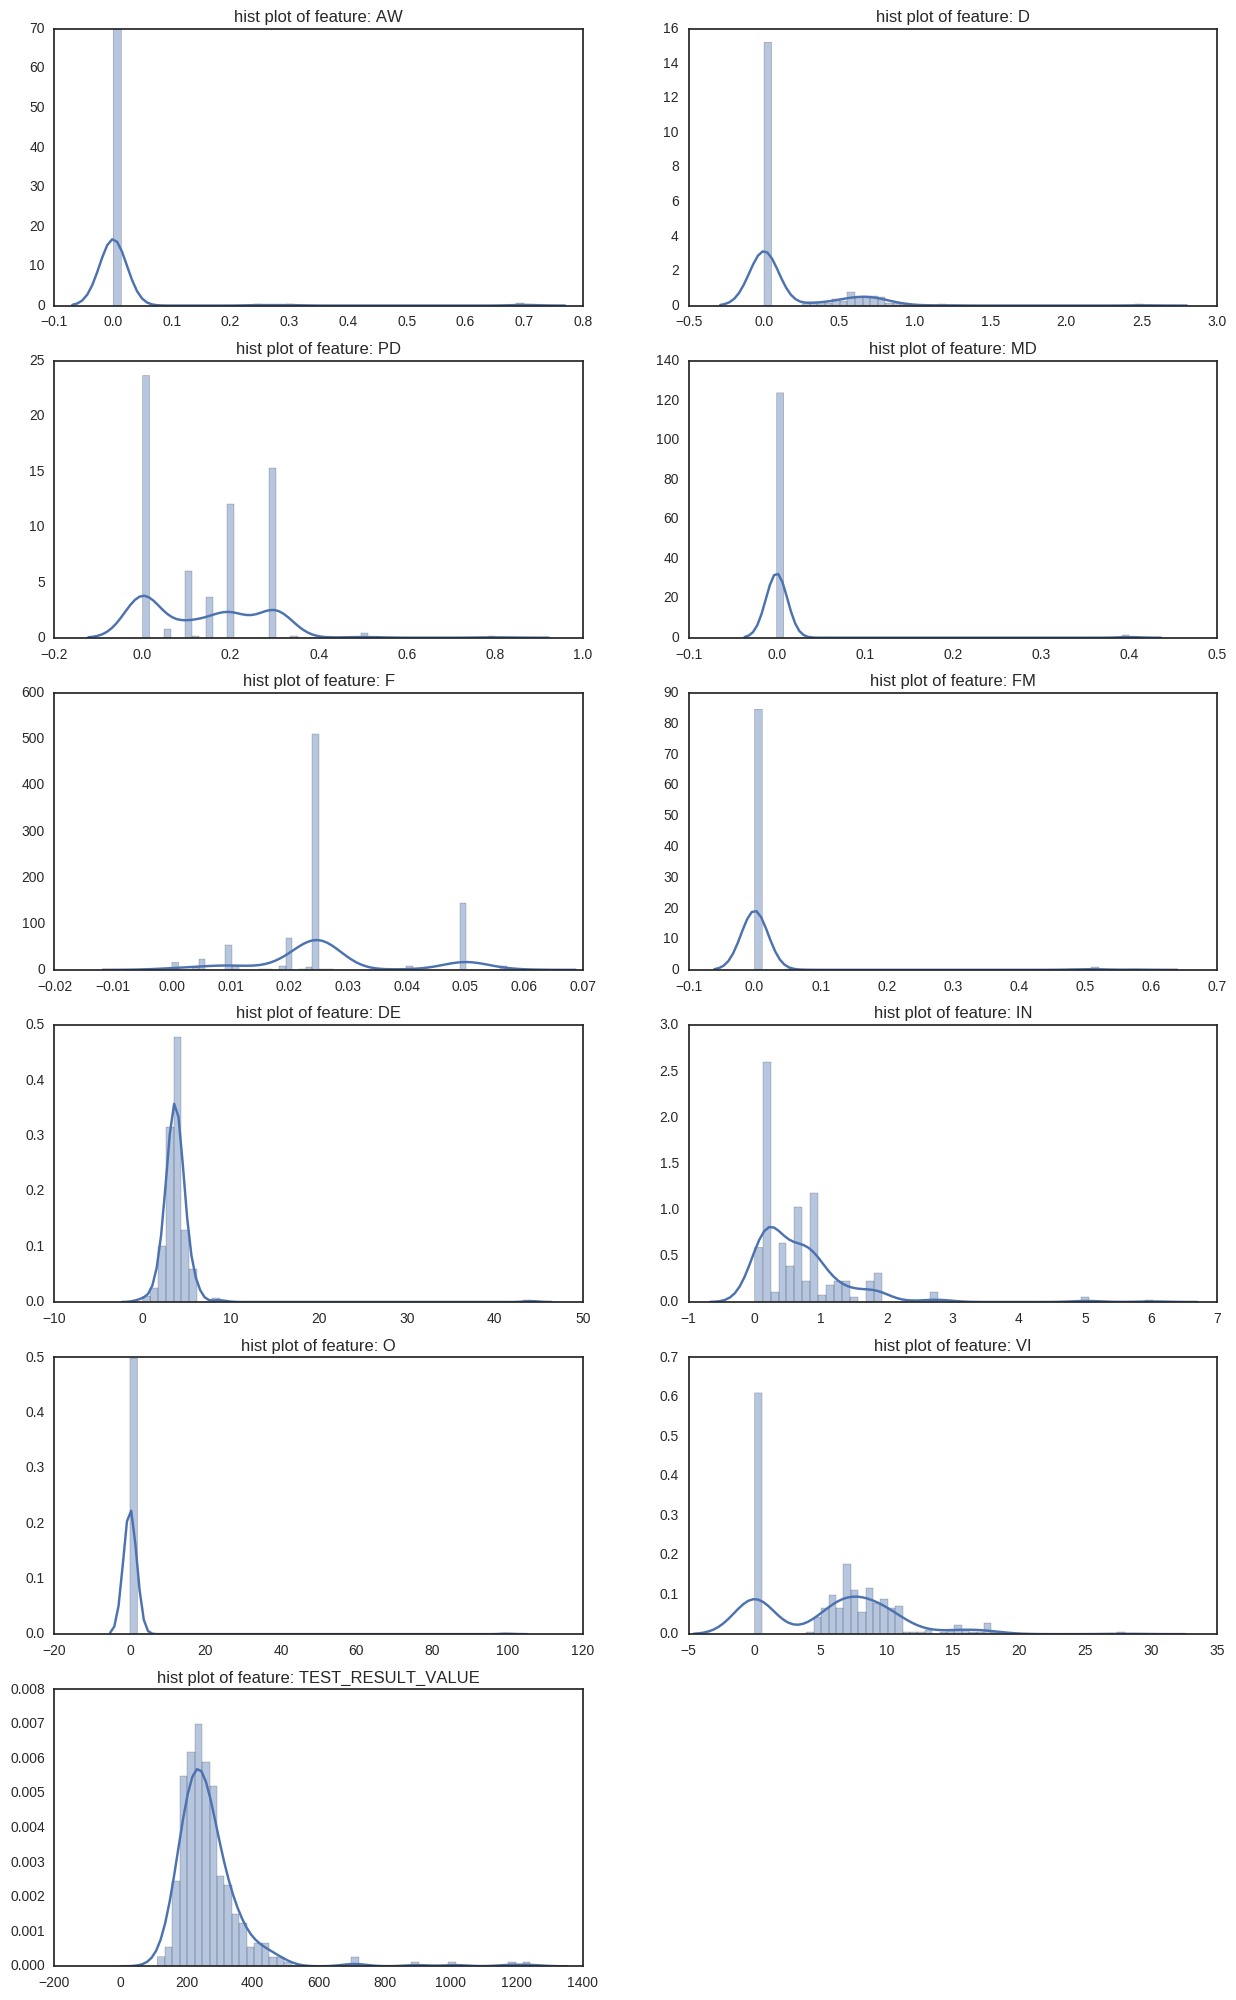

In [11]:
skewed_cont_columns = []
for i, cn in enumerate(df.columns):
    if skewness_list[i] >= 0.25:
        skewed_cont_columns.append(cn)
        
plt.figure(figsize=(15,25))
gs = gridspec.GridSpec(6, 2)
for i, cn in enumerate(skewed_cont_columns):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn], bins=50)
    ax.set_xlabel('')
    ax.set_title('hist plot of feature: ' + str(cn))
plt.show()

In [7]:
encode_numeric_zscore_list(df, ['AW', 'D', 'PD', 'MD', 'F', 'FM', 'ZN', 'DE', 'IN', 'O', 'VI', 'DI'])
           
y = df['TEST_RESULT_VALUE']
x = df.drop(['TEST_RESULT_VALUE'], axis=1)

RANDOM_STATE = randint(1,429496)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=RANDOM_STATE)

params = {
    'min_child_weight': 1,
    'eta': 0.001,
    'colsample_bytree': 0.5,
    'max_depth': 12,
    'subsample': 0.8,
    'alpha': 1,
    'gamma': 1,
    'silent': 1,
    'verbose_eval': False,
    'seed': RANDOM_STATE,
    'eval_metric': 'mae'
}

xgtrain = xgb.DMatrix(x_train, label=y_train)
xgtest = xgb.DMatrix(x_test, label=y_test)

watchlist = [(xgtrain, 'train'), (xgtest, 'eval')]                   

In [8]:
model = xgb.train(params, xgtrain, 100000, watchlist, verbose_eval=100,early_stopping_rounds=300)     

[0]	train-mae:271.687	eval-mae:264.944
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 300 rounds.
[100]	train-mae:246.315	eval-mae:239.721
[200]	train-mae:223.485	eval-mae:217.02
[300]	train-mae:202.826	eval-mae:196.482
[400]	train-mae:184.248	eval-mae:177.98
[500]	train-mae:167.473	eval-mae:161.309
[600]	train-mae:152.281	eval-mae:146.196
[700]	train-mae:138.638	eval-mae:132.582
[800]	train-mae:126.285	eval-mae:120.485
[900]	train-mae:115.136	eval-mae:109.702
[1000]	train-mae:105.079	eval-mae:99.8927
[1100]	train-mae:96.2126	eval-mae:91.3979
[1200]	train-mae:88.3296	eval-mae:84.9463
[1300]	train-mae:81.303	eval-mae:79.8557
[1400]	train-mae:75.1784	eval-mae:75.8551
[1500]	train-mae:69.7246	eval-mae:72.5523
[1600]	train-mae:64.8883	eval-mae:70.075
[1700]	train-mae:60.6378	eval-mae:68.5881
[1800]	train-mae:56.9067	eval-mae:67.4236
[1900]	train-mae:53.5172	eval-mae:66.3572
[2000]	train-mae:50.5216	eval-mae:

Validation MAE=36.40165710449219
Validation R2 score=0.605052311580363


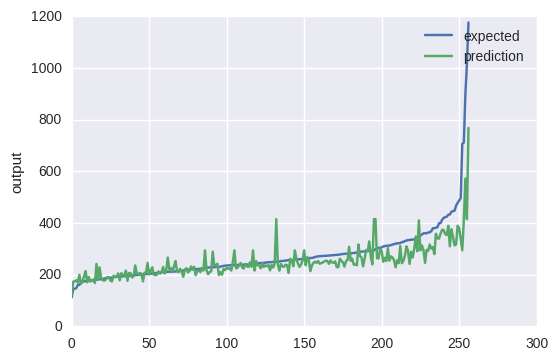

In [9]:
predictions = model.predict(xgtrain)
testlabels = xgtrain.get_label()
mae = mean_absolute_error(predictions, testlabels)
print("Validation MAE={}".format(mae))
r2score = r2_score(testlabels, predictions)
print("Validation R2 score={}".format(r2score))

chart_regression(predictions, testlabels)  

In [29]:
#Outlier detection
import statsmodels.api as smapi
import statsmodels.graphics as smgraphics
from sklearn.ensemble import IsolationForest
# Make graph #
#regression = smapi.OLS(x, y).fit()
#figure = smgraphics.regressionplots.plot_fit(regression, 0)

clf = IsolationForest(max_samples=100, random_state=42)
clf.fit(x)
y_pred_outliers = clf.predict(x)

In [30]:
print(y_pred_outliers)

[ 1  1  1  1  1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1
  1 -1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1 -1 -1 -1 -1 -1
  1 -1 -1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
